# 6 Viterbi Algorithm

## a 概要

定常な一次HMMを想定.潜在変数$u$，観測変数$x$が次のようであるとする

$$
u_0 \sim A_0(\cdot) \\
u_{t + 1} | u_t \sim A(\cdot|u_t) \\
x_t | u_t \sim \pi(\cdot | u_t)
$$

目的は$X_T = x_1 x_2 \cdots x_T$を観測して，尤度を最大にする潜在状態$U_T = u_1 u_2 \cdots u_T$を得ることである．
すなわち

\begin{align}
U_{T}^{*} &= \arg\max_{U_T} p(U_T, X_T) \\
&= \arg\max_{U_T} A_0(u_0)\prod\limits_{t = 1}^{T} A(u_{t} | u_{t - 1} ) \pi(x_t | u_t)
\end{align}


素直にこのアルゴリズムを実行してしまうと$O( |\mathcal{U}|^{T} )$の計算量がかかってしまう．Markov性に注目することで$O( T|\mathcal{U}|^2)$のDPに落とし込められる．これがViterbiアルゴリズムの概要である．

## b アルゴリズム

\begin{align}
\mathbb{R}_{\leq0} \ni \delta_{t}(u_t) 
&:= \log \Big(
  t\mbox{ステップ目の状態が}u_t\mbox{であると固定したうえで，}X_t\mbox{を観測する確率の}\max
  \Big) \\
&= \max_{U_{t-1}}  \log p(U_{t-1}, u_t = u_t, X_{t}) \\
\mathcal{U}_{t-1} \ni \psi_{t}(u_t) &:= \bigg\{
 \log \Big(
  t\mbox{ステップ目の状態が}u_t\mbox{であると固定した上で，}X_t\mbox{を観測する確率の}\max \Big) \mbox{を指定する状態}u_{t-1}
  \bigg\} \\
  &= \arg\max_{u_{t-1}}\big\{ \delta_{t-1}(u_{t-1})  + \log  A(u_t|u_{t-1}) \big\} +\log  \pi(x_{t} | u_{t})
\end{align}
とおくと潜在変数のmarkov性よりDPがつくれる．

**DP**<br>
$t = 0, 1, \cdots T-1$に対して
\begin{align}
\mathbb{R}_{\leq0} \ni \delta_{t + 1}(u') &=  \max_{u_t} \Big\{\delta_t (u_t) + \log  A (u' | u_t ) \Big\} + \log  \pi (x_{t + 1} | u') \\
\mathcal{U}_t \ni \psi_{t + 1}(u') &=   \arg\max_{u_t} \Big\{ \delta_t (u_t)  +\log A (u' | u_t ) \Big\} 
\end{align}

**初期条件**
\begin{align}
\delta_0(u_0) &= \pi_o(u_o) \\
\psi_0(u_0) &= \{\}
\end{align}

**結果**
\begin{align}
P^* &= \max_{u_T} \delta_T (u_T) \\
u_T^* &= \arg\max_{u_T} \delta_{t}(u_T)
\end{align}

**状態系列のバックトラック**
\begin{align}
u_t^* &= \psi_{t + 1} (u_{t + 1}^*),t = T-1, \cdots, 0
\end{align}


## Pythonおよび必要なライブラリをインポートする．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks"

In [ ]:
!python3 --version

import random

Python 3.7.14


In [ ]:
import matplotlib as makeMSL
import matplotlib.pyplot as plt
import numpy as np
import math

以下は$\mbox{erfc}$関数を読み込むためのライブラリ

In [ ]:
from scipy import special
from scipy.linalg import sqrtm

## Viterbi Algorithm用のモジュール

### エンコーダー
情報$X_T \in \{0, 1\}^T$を状態$S_T \in \{00, 01, 10, 11\}^T$を介して畳み込み符号$U_T \in \{00, 01, 10, 11\}^T$として出力する

\begin{align}
E: \{0, 1\}^T \ni X_T &\mapsto U_T \in \{00, 01, 10, 11\}^T \\
\end{align}

$x_{t + 1}$が入力されると直前の状態$s_{t} = BC$に応じて$u_{t +1}$にエンコードされ，状態が$s_{t + 1}$に更新される

\begin{align}
(x_{t + 1}, s_t) \mapsto (u_{t + 1}, s_{t + 1} )
\end{align}

**$(u_{t + 1}, s_{t + 1})$の表**

|  $s_{t} \backslash x_{t + 1}$  |  $00$  |  $01$ |
| ---- | ---- | --- |
|  $00$  |  $(00, 00)$  |  $(11, 01)$  |
|  $01$  |  $(10, 10)$  |  $(01, 11)$  |
|  $10$  |  $(11, 00)$  |  $(00, 01)$  |
|  $11$  |  $(01, 10)$  |  $(10, 11)$  |

In [ ]:
'''
畳み込み符号エンコーダー
'''
class EncoderConv:
  def __init__(self):
    return
  
  '''
  情報Xを畳み込み符号U_Tにエンコードする
  @param X                np.ndarray 情報{0, 1}^{T}
  @param doesReturnState bool       内部状態まで返すか否か
  
  @return U                np.ndarray 畳み込み符号 {00, 01, 10, 11}^T
  @return S                np.ndarray 内部状態 {00, 01, 10, 11}^{T + 1}     (if doesReturnState == True)
  '''
  def encode(self, X, doesReturnState = False):
    T = X.shape[1]
    S = np.zeros( shape = (1, T + 1), dtype = 'int')
    U = np.zeros( shape = (1, T), dtype = 'int')

    '''初期条件(t = 0)'''
    S[0][0] = 0

    '''情報x'を受け取り直前の状態sから動的に(u', s')を構成'''
    for t in range(T):
      B = S[0][t] & 1
      C = S[0][t] >> 1

      u_upper = X[0][t] ^ B ^ C
      u_lower = X[0][t] ^ C
      U[0][t] = (u_upper << 1) + u_lower
      
      C = B
      B = X[0][t]
      S[0][t + 1] = (C << 1) + B
    

    if doesReturnState == False:
      return U
    else:
      return U, S

### デコーダー
畳み込み符号$U_T$から情報$X_T$をデコードする

\begin{align}
D: \{00, 01, 10, 11\}^T \ni U_T &\mapsto X_T \in \{0, 1\}^T  \\
\end{align}

$u_{t + 1}$を観測すると直前の状態$s_{t} = BC$(こちらも複合する)に応じて$x_{t +1}$にデコードされ，状態が$s_{t + 1}$に更新される

\begin{align}
(u_{t + 1}, s_{t}) &\mapsto (x_{t + 1}, s_{t + 1}) \\
x_{t + 1} &= \arg_{x_{t + 1}} I\Big[ \rm{encode}(x_{t+1}; s_t) = u_{t + 1} \Big]
\end{align}

In [ ]:
'''
畳み込み符号デコーダー
'''
class DecoderConv:
  def __init__(self):
    return
  
  '''
  畳み込み符号Uを状態Xにエンコードする
  @param U                np.ndarray 畳み込み符号 {00, 01, 10, 11}^T
  @param doesReturnState bool       内部状態まで返すか否か
  
  @return X                np.ndarray 情報 {0, 1}^T
  @return S                np.ndarray 内部状態 {00, 01, 10, 11}^{T + 1}     (if doesReturnState == True)
  '''
  def decode(self, U, doesReturnState = False):
    T = U.shape[1]
    S = np.zeros( shape = (1, T + 1), dtype = 'int')
    X = np.zeros( shape = (1, T), dtype = 'int')

    '''初期条件(t = 0)'''
    S[0][0] = 0 

    '''畳み込み符号u'を受け取り直前の状態sから動的に(x', s')を構成'''
    for t in range(T):
      B = S[0][t] & 1
      C = S[0][t] >> 1

      for x in range(2):
        u_upper = x ^ B ^ C
        u_lower = x ^ C
        x_encoded = (u_upper << 1) + u_lower
        if x_encoded == U[0][t]:
          X[0][t] = x

          C = B
          B = x
          S[0][t + 1] = (C << 1) + B
          break
    

    if doesReturnState == False:
      return X
    else:
      return X, S

### 畳み込み符号用のViterbiアルゴリズム

In [ ]:
'''
Viterbiアルゴリズム用のモジュール
'''

class ViterbiModuleConv:
  def __init__(self):
    self.setS = {0, 1, 2, 3}
    self.setSdim = 4
    self.setU = {0, 1, 2, 3}
    self.setUdim = 4
    
    '''
    p(s'|s, u')を簡単にしたもの
    (S', S, U) -> R
    ステップt = 0, 1, t, T - 2, T - 1に応じてセット　(ただし1 < t < T - 2)
    '''
    self.A_0, self.A_1, self.A_t, self.A_TminusTwo, self.A_TminusOne = None, None, None, None, None
    self.setA()

    '''
    XTのステップ数
    '''
    self.T = None
    return

  '''
  Viterbi algorithm
  @param X             np.ndarray 観測系列 {00, 01, 10, 11}^T
  @param doesReturnAll bool       内部状態δとU*を返すかどうか

  @return Ustar         np.ndarray 推測系列 {00, 01, 10, 11}^|S|^T 
  (@return Ustar, delta) np.ndarray 推測系列 {00, 01, 10, 11}^T
                         delta      スコア     Z^|S|^T
  '''
  def doViterbi(self, X, doesReturnDelta = False):
    T = X.shape[1]
    self.setT(T)

    delta = np.zeros( shape = (self.setSdim, T + 1), dtype = 'int')
    psi   = np.zeros( shape = (self.setSdim, T), dtype = 'int')

    '''初期条件'''
    delta[0][0] = 100

    '''DP'''
    for t in range(T):

      '''s'を固定して各s'に対して最適なu'*を求める'''
      for sDash in self.setS:

        '''最適なu*候補のu'を舐めてスコアδを更新できるならする'''
        for uDash in self.setU:
          for s in self.setS:
            if self.A(sDash, s, uDash, t) == 1 and delta[sDash][t + 1] < delta[s][t] + self.score(uDash, X[0][t]):
              delta[sDash][t + 1] = delta[s][t] + self.score(uDash, X[0][t])
              psi[sDash][t] = uDash
    
    Ustar = self.traceback(delta, psi)
    if doesReturnDelta == False:
      return Ustar
    else:
      return Ustar, delta
  
  '''
  トレースバック
  @param psi      np.ndarray ステップtまで見て状態s_tを固定したとき同時確率maxを指定する状態s_{t-1} {00, 01, 10, 11}^T
  @return Ustar    np.ndarray Xを観測したときに同時確率をmaxにする系列U* = arg max U p(U, X = X)
  '''
  def traceback(self, delta, psi):
    Ustar = np.zeros( shape = (1, self.T), dtype = 'int')

    '''
    初期条件
    U*_{T - 1} =  argmax_{ U_{T - 1} } delta_{T}( U_{T - 1} )
    畳み込み符号のラストが状態00で終わるように設定しているので
    U*_{T - 1} = argmax delta_{T}(00) = psi_{T - 1} (00)
    '''
    Ustar[0][self.T - 1] = psi[0][self.T - 1]

    '''
    DP
    '''
    for t in range(self.T - 2, -1, -1):
      Ustar[0][t] = psi[ Ustar[0][t + 1] ][t]

    return Ustar

  '''
  遷移確率p_t(s'|s, u')を簡単にしたものを示すメンバ変数セッター
    p: (S', S, U, T) -> {0, 1}
  '''
  def setA(self):
    '''
    t = 0のとき
    {00, 01} = S' <- S * U = {00}^{00, 11}のみである．
    '''
    self.A_0 = np.array([
        [
          [1, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ]
    ])

    '''
    t = 1のとき
    s* = 00 <- S * U = {00}^{00}
    s* = 01 <- S * U = {00}^{11}
    s* = 10 <- S * U = {01}^[10]
    s* = 11 <- S * U = {01}^{01}　のみ
    '''
    self.A_1 = np.array([
        [
          [1, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ]
    ])
    '''
    1 < t < T - 2のとき
    '''
    self.A_t = np.array([
        [
          [1, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 1],
          [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 0],
         [0, 1, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 1, 0]
        ]
    ])

    '''
    t = T - 2のとき
    {00} = S' <- S * U = (00, 00), (10, 11)
    {10} = S' <- S * U = (01, 10), (11, 01)のみ
    '''
    self.A_TminusTwo = np.array([
        [
          [1, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 1],
          [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 0],
         [0, 1, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ]
    ])

    '''
    t = T - 1のとき
    {00} = S' <- S * U = (00, 00), (10, 11)のみ
    '''
    self.A_TminusOne = np.array([
        [
          [1, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 1],
          [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ],
        [
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]
        ]
    ])



  '''
  ステップ数を示すメンバ変数のセッター
  @param T      int ステップ数
  '''
  def setT(self, T):
    self.T = T
      
  '''
  p_t(s'|s, u')を簡単にしたものを返す
    (S', S, U, T) -> R
  @param sDash int         状態s_{t + 1}
  @param s      int         状態s_t
  @param uDash int         状態u_{t + 1}
  @param t      int         ステップ

  @return p      int  遷移行列を簡単にしたもの {0, 1}
  '''
  def A(self, sDash, s, uDash, t):
    return self.getA(sDash, s, uDash, t)
  

  '''
  遷移確率を簡略化したもののを返すゲッター
  @param sDash int         状態s_{t + 1}
  @param s      int         状態s_t
  @param uDash int         状態u_{t + 1}
  @param t      int         ステップ

  @return p      int  遷移行列を簡単にしたもの {0,1}
  '''
  def getA(self, sDash, s, uDash, t):
    if t == 0:
      return self.A_0[sDash][s][uDash]
    elif t == 1:
      return self.A_1[sDash][s][uDash]
    elif 1 < t and t < T - 2:
      return self.A_t[sDash][s][uDash]
    elif t == T - 2:
      return self.A_TminusTwo[sDash][s][uDash]
    elif t == T - 1:
      return self.A_TminusOne[sDash][s][uDash]
    else:
      raise ValueError("unexpected value(t) are found.")

  '''
  2ビットのs, xのハミング距離に基づいたスコア = 2 - dist(s, x)
  @param s     int 2ビット符号
  @param x     int 2ビット符号
  @reutrn score int スコア
  '''
  def score(self, s, x):
    return 2 - self.hammingDistance(s, x)

  '''
  2ビットのs, xのハミング距離
  @param s int 2ビット符号
  @param x int 2ビット符号
  @return d int ハミング距離
  '''
  def hammingDistance(self, s, x):
    delta = s^x
    d = (delta % 2) + (delta // 2)
    return d

In [ ]:
encoder = EncoderConv()
decoder = DecoderConv()

In [ ]:
viterbiModule = ViterbiModuleConv()

In [ ]:
T = 128
X = np.random.randint(low = 0, high = 2, size = (1, T))
X[0][T - 2] = X[0][T - 1] = 0
X

array([[0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]])

In [ ]:
U = encoder.encode(X)

In [ ]:
U

array([[0, 0, 3, 2, 0, 2, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 1, 3, 3, 1, 1, 0,
        2, 3, 0, 3, 2, 0, 1, 1, 3, 3, 2, 3, 0, 0, 3, 2, 0, 1, 2, 2, 2, 1,
        0, 1, 1, 3, 3, 2, 3, 0, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 1, 0, 2,
        0, 2, 0, 1, 1, 3, 3, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1,
        3, 0, 3, 1, 1, 0, 1, 1, 3, 0, 3, 2, 0, 2, 3, 3, 2, 3, 3, 1, 2, 2,
        2, 2, 2, 1, 3, 0, 0, 3, 2, 3, 3, 1, 1, 3, 3, 2, 3, 0]])

In [ ]:
Ustar, delta = viterbiModule.doViterbi(U, True)

In [ ]:
Ustar

array([[3, 1, 3, 1, 3, 0, 0, 1, 3, 0, 1, 2, 2, 3, 0, 1, 3, 0, 1, 3, 1, 2,
        3, 1, 2, 2, 2, 2, 3, 1, 2, 3, 1, 3, 0, 0, 0, 0, 0, 1, 3, 0, 1, 2,
        3, 0, 0, 1, 2, 2, 2, 3, 1, 3, 1, 2, 2, 2, 3, 1, 3, 0, 0, 0, 1, 2,
        2, 3, 1, 2, 2, 3, 0, 0, 0, 1, 2, 3, 1, 2, 3, 0, 0, 1, 2, 3, 1, 2,
        3, 0, 0, 0, 0, 1, 2, 2, 3, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 3, 1, 2,
        3, 0, 1, 2, 3, 0, 0, 0, 0, 0, 1, 3, 1, 2, 3, 1, 3, 0]])

In [ ]:
delta

array([[100, 102, 104, 104, 105, 108, 109, 112, 113, 115, 117, 120, 121,
        123, 125, 128, 129, 131, 136, 136, 137, 139, 142, 143, 148, 150,
        150, 151, 154, 155, 157, 162, 162, 163, 168, 170, 172, 172, 173,
        176, 177, 179, 181, 183, 185, 188, 189, 191, 196, 196, 197, 202,
        204, 204, 205, 210, 210, 211, 216, 216, 217, 222, 222, 223, 225,
        228, 229, 232, 233, 236, 237, 239, 244, 244, 245, 247, 249, 252,
        253, 255, 257, 260, 261, 263, 265, 268, 269, 271, 273, 278, 280,
        280, 281, 283, 286, 287, 289, 294, 296, 296, 297, 300, 301, 306,
        306, 307, 312, 312, 313, 315, 317, 319, 321, 323, 325, 330, 332,
        334, 334, 335, 340, 340, 341, 343, 348, 348, 349, 354, 356],
       [  0, 100, 102, 106, 105, 110, 109, 114, 113, 115, 117, 122, 121,
        123, 125, 130, 129, 131, 134, 138, 137, 139, 144, 143, 146, 148,
        152, 151, 156, 155, 157, 160, 164, 163, 166, 168, 170, 174, 173,
        178, 177, 179, 181, 183, 185, 190, 189, 191, 19

In [ ]:
#エラー率
print(np.sum(Ustar ^ U) / (2 * T) )

0.73828125


## 通信モデルに基づいたシミュレーション用のモジュール

*  情報源
*  情報源符号器
*  通信路符号器
*  通信路
*  白色ガウス雑音
*  通信路複復号器
*  情報源復号器

### 情報源
numpy.randomでも代用可

In [ ]:
'''
情報源クラス
'''
class InformationSource:
  def __init__(self,
                 N = 9,   #次数
                 a = 4, b = 9 #帰還タップ
                 ):
    self.N = N
    self.a = a
    self.b = b

  
  '''
  乱数(M系列)を発生させる
  @param informationSize int             発生させる乱数の個数
  @return information     numpy.ndarray 乱数
  '''
  def outputInformation(self, informationSize):
    information = np.empty(informationSize, dtype = int)

    for i in range(informationSize):
      if i < self.N :
        information[i] = random.randrange(2)
      else :
        information[i] = information[i - self.a] ^ information[i - self.b]

    return information

### 情報源符号器

In [ ]:
'''
情報源符号器
'''
class Encoder:
  '''
  @param M int 符号のビット数
  '''
  def __init__(self,
               M #符号のビット数
               ) :
    self.M = M

    #２進数のマスク
    self.mask = np.array([1 << bit for bit in range(M)])
  
  '''
  0/1乱数をM[bit]の符号にする
  @param information numpy.ndarray 0/1の乱数(情報)
  @return data        numpy.ndarray 符号
  '''
  def encode(self,
             information):
    information2 = np.concatenate([information, information])

    data = np.array([
        self.mask @ information2[i: i + self.M] 
        for i in range(information.size)
    ])
    data = np.reshape(data, (1, data.size))

    return data

    return np.array([
        np.array([self.mask @ information2[i: i + self.M] ])
        for i in range(information.size)
    ])
    
    '''
    return np.array([
        self.mask @ information2[i: i + self.M]
        for i in range(information.size)
    ])
    '''

### 通信路符号器

Mは単位が[bit]とする
**MPSKのとき**$$\mathbb{Z} \mapsto \mathbb{C}:x\mapsto \sqrt{P_s} \cdot  \exp\Big(j\frac{2\pi}{2^M}x\Big)$$  <br>

**MQAMのとき**<br>データ$x$を上位ビット$x^U$，下位ビット$x^L$に分けて
$$
f:\times2d - (2^{M/2} - 1)d
$$
を作用させてそれぞれ複素信号$s$の実部$s^I$と虚部$s^Q$とする． <br>
ただし$2d$は信号点間隔であり，電力$\mathbb{E}\big[|s|^2\big]$を$P_S$に固定するとき
$$
P_S = 
\frac{1}{2^M} \cdot
\sum_{x \in \{0, 1, \cdots 2^M - 1\} }
  \Bigg\| f(x^U) + jf(x^L) \Bigg\|^2
$$

より$d$は以下のように確定する.

$$
d = \sqrt{\frac{3}{2} \frac{P_S}{2^M - 1 } }
$$

In [ ]:
'''
通信路符号器
'''
class Modulator:
  '''
  constructor
  @param M              int   多値数[bit] 単位がビットであることに注意
  @param mode          str   変調方式 ex) mode = "PSK", mode = "QAM"
  @param isGrayCode    bool  グレイコードにするか否か
  @param powerOfSignal float １シンボルあたりの送信電力 (１ビットあたりの送信電力ではない！)
  '''
  def __init__(self,
               M,
               mode,
               isGrayCode = True,
               powerOfSignal  = 1.0
               ):
    
    self.M = M
    self.mode = mode
    self.isGrayCode = isGrayCode
    self.powerOfSignal = powerOfSignal

    if mode == "QAM":
      self.d = math.sqrt(
          1.5 * self.powerOfSignal / ( (1 << self.M) - 1 )
      )
    
    elif mode == "PSK":
      self.A  = math.sqrt( self.powerOfSignal )

  '''
  変調
  @param data     np.ndarray データ
  @return symbol  np.ndarray シンボル
  '''
  def modulate(self,data):
    if self.mode == "PSK":
      if self.isGrayCode == True:
        data = self.grayEncode(data)
      return self.A * np.exp(1j * 2.0 * np.pi/ (1 << self.M) * data)
    
    if self.mode == "QAM":
      x_U = self.sliceUpperBit(data)
      if self.isGrayCode == True:
        x_U = self.grayEncode(x_U)

      x_L = self.sliceLowerBit(data)
      if self.isGrayCode  == True:
        x_L = self.grayEncode(x_L)

      s_I = self.f(x_U)
      s_Q = self.f(x_L)
      return s_I + 1j * s_Q
  
  '''
  上位ビット取得
  @param x    np.ndarray {0, 1, ..., 2^M - 1} データ
  @return x_U np.ndarray 上位ビット
  '''
  def sliceUpperBit(self, x) :
    return (
        x >> (self.M//2)
    )
  
  '''
  下位ビット取得
  @param x    np.ndarray {0, 1, ..., 2^M - 1} データ
  @return x_D np.ndarray 下位ビット
  '''
  def sliceLowerBit(self, x) :
    return x & (
        ( 1 << (self.M//2) ) - 1
    )
  
  '''
  M/2ビットを等間隔に配置
  @param x_           np.ndarray  M/2ビットのデータ
  @return symbolPart   np.ndarray  信号点のI/Q座標
  '''
  def f(self, x_):
    return self.d * (
          x_ * 2 - (
              (1 << (self.M//2) ) - 1
            )
        )
  
  '''
  グレイコードにする
  @param n            array_like integer
  @return              array_like gray coded object
  '''
  def grayEncode(self, n):
    return n ^ n >> 1
  
  '''
  グレイコードから直す
  @param n           array_like gray coded object
  @return             array_like gray decoded object
  '''
  def grayDecode(self, n):
    i = isinstance(n, int)
    n = np.array([n]) if i else n.copy()
    m = n >> 1
    while not (m == 0).all():
        n ^= m
        m >>= 1
    return n[0] if i else n
  
  '''
  信号点配置の表示と電力を計算する
  '''
  def debug(self):
    dataSet = np.arange(1 << self.M)
    dataset = self.grayEncode(dataSet)
    symbolSet = self.modulate(dataSet)

    plt.scatter( symbolSet.real, symbolSet.imag, label = "{}{}".format(1 << self.M, self.mode))
    for n in range(1 << self.M):
      data = dataSet[n]
      symbol = symbolSet[n]
      plt.annotate("${}$".format( format(data, 'b') ), xy = (symbol.real, symbol.imag))

    plt.xlabel("I")
    plt.ylabel("Q")


    plt.legend()
    plt.savefig("{}{}.png".format(
        1 << self.M,
        self.mode  
      )
    )

    plt.show()

    print("calculated power of signal: {}".format(
        math.sqrt(
          np.mean( np.abs(symbolSet) ** 2 )
        )
      )
    )

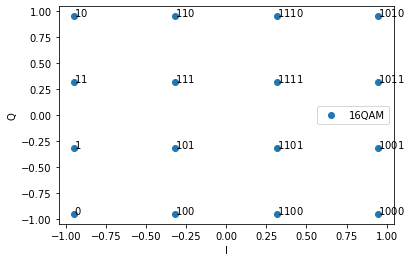

calculated power of signal: 1.0


In [ ]:
modulatorTest = Modulator(
    M = 4,
    mode = "QAM",
    isGrayCode = True
)

modulatorTest.debug()

### 通信路

In [ ]:
'''
通信路
'''
class Channel:
  '''
  @param channelMatrix np.ndarray チャネル行列H
  '''
  def __init__(self, channelMatrix):
    self.channelMatrix = channelMatrix
  
  '''
  シンボルsを通信路Hに通して出力( y = Hu 出力)
  @param symbol np.ndarray 入力シンボル
  @reutrn         np.ndarray 出力シンボル
  '''
  def transport(self, symbol):
    return self.channelMatrix @ symbol

In [ ]:
'''
クロネッカーモデル通信路
'''
class KroneckerChannel(Channel):
  '''
  @paran Nt   送信アンテナ数
  @paran Nr   受信アンテナ数
  @param rho 相関係数
  @param
  '''
  def __init__(self, Nt, Nr, rho):
    self.Nt = Nt
    self.Nr = Nr
    self.rho = rho
    
    self.Rt = self.Nt * self.exponentialCorrelationMatrix(self.Nt, self.rho)
    self.G = self.gaussianMatrix(self.Nr, self.Nt)
    self.Rr = self.Nr * self.exponentialCorrelationMatrix(self.Nr, self.rho)
    self.kappa = np.trace(self.Rt)


    self.H = self.calcKroneckerChannel(self.Rt, self.G, self.Rr, self.kappa)
  
  def exponentialCorrelationMatrix(self, N, rho):
    mat = np.array([
        [ i - j for j in range(N) ]
        for i in range(N)
    ])
    mat = np.abs(mat)
    mat = np.power(rho, mat)
    return mat
  
  def gaussianMatrix(self, rowNum, colNum):
    mat = np.array([
        [
            random.gauss(mu = 0, sigma = np.sqrt(0.5) ) + 1j * random.gauss(mu = 0, sigma = np.sqrt(0.5) ) 
            for col in range(colNum)
        ]
        for row in range(rowNum)
    ])
    return mat

### 白色ガウス雑音加算器
複素ガウス分布に従う雑音$\boldsymbol{n}$をBox-Muller法で発生させる．
$$
\boldsymbol{n} \sim \mathcal{CN}( 0, \sigma^2  )
$$
実部と虚部は$\mathcal{N}(0, \sigma^2/2)$に従うことに注意

In [ ]:
class AwgnAdder:
  '''
  constructor
  '''
  def __init__(self):
    return
  
  '''
  シンボルにガウスノイズn ~ CN(0, σ^2)をのせて返す
  @param symbol  np.ndarray       シンボル
  @param variance float            分散
  @return symbolNoizes np.ndarray ノイズが加算されたシンボル
  '''
  def addAwgn(self, symbol, variance):
    noizeVector = np.array([
          self.generateGaussian(variance) for _ in range(symbol.size)
        ])
    noizeMatrix = noizeVector.reshape( symbol.shape )
    return symbol + noizeMatrix

  ''''
  複素標準ガウス雑音n ~ CN(0, σ^2)生成
  @param variance float     分散σ^2
  @return gaussian complex 複素標準ガウス雑音n ~ CN(0, σ^2)
  '''
  def generateGaussian(self, variance):
    #確率変数x_1, x_2 ~ U(0, 1)
    x_1 = random.uniform(0.0, 1.0)
    x_2 = random.uniform(0.0, 1.0)

    #確率変数x_1, x_2を変換して標準正規分布に従う確率変数y_1, y_2とする
    y_1 = np.sqrt(-2.0 * np.log(x_1)) * np.cos(2.0 * np.pi * x_2)
    y_2 = np.sqrt(-2.0 * np.log(x_1)) * np.sin(2.0 * np.pi * x_2)

    return np.sqrt( variance / 2.0) * (y_1 + 1j * y_2)

### 通信路複復号器

***MPSK M$[\rm{bit}]$*** のとき <br>
受け取った信号$y$に対して
$$
\hat{x} = \rm{round} \Bigg( 
  \frac{
  \rm{arg}(y)
}{
  2 \pi / 2^M
} \Bigg)
$$
と復調する．<br>

***MQAM M$[\rm{bit}]$***のとき <br>
受け取った信号$y = y^I + j y^Q$に対して
$$
\hat{x}^{(\cdot)}  = \rm{round}\Bigg(
  \frac{1}{2}
  \bigg\{
    \frac{y^{(\cdot)} }{d} + 2^{M/2} - 1
  \bigg\}
  \Bigg)
$$
として上位ビット$\hat{x}^U$および下位ビット$\hat{x}^D$と復調する. <br>
ただし$\hat{x}^{(\cdot)} < 0$のとき$\hat{x}^{(\cdot)} = 0$, $\hat{x}^{(\cdot)} \geq 2^{M/2}$のとき$\hat{x}^{(\cdot)} = 2^{M/2} - 1$とする．<br>

また，計算量はあるが確実な方法として最小ノルムを指定するシンボルを推定地にする復調法も実装した．すなわち
$$
\hat{x} = \rm{arg min}_{x \in \{0, 1, \cdots, 2^M-1\} } \Big\| \rm{modulate} (x) - y \Big\|
$$

In [ ]:
class Demodulator(Modulator):
  '''
  constructor
  @param M              int   多値数[bit] 単位がビットであることに注意
  @param mode          str   変調方式 ex) mode = "PSK", mode = "QAM"
  @param argmin         bool argminで復調するか否か
  @param powerOfSignal float １シンボルあたりの送信電力 (１ビットあたりの送信電力ではない！)
  '''
  def __init__(self,
               M,
               mode,
               isGrayCode = True,
               powerOfSignal  = 1.0,
               argmin = False
               ):
    super().__init__(M, mode, isGrayCode, powerOfSignal)
    self.argmin = argmin
    self.dataOrigin = np.arange(1 << self.M)
    if self.isGrayCode == True:
      self.dataOrigin =  self.grayEncode( self.dataOrigin )
    self.symbolOrigin = self.modulate(self.dataOrigin)
    
    

  '''
  復調
  @param symbolReceived         np.ndarray 受け取ったシンボル
  @return dataDemodulated       np.ndarray 復調されたデータ
  '''
  def demodulate(self, symbolReceived):
    if self.argmin == True:
      dataDemodulated =  np.array([
          np.argmin(
              abs(self.symbolOrigin - symbolReceived_) 
          )
          for symbolReceived_ in symbolReceived
      ])

      if self.isGrayCode == True:
        dataDemodulated = self.grayDecode( dataDemodulated )

    elif self.mode == "PSK":
      dataDemodulated = np.angle( symbolReceived )
      dataDemodulated = dataDemodulated / (
          2.0 * np.pi / ( 1 << self.M )
      )
      dataDemodulated = dataDemodulated.round()
      dataDemodulated = np.array(dataDemodulated.round(), dtype = 'int')
      dataDemodulated = np.where(dataDemodulated < 0,
                                   dataDemodulated + (1 << self.M),
                                   dataDemodulated)
      if self.isGrayCode == True:
        dataDemodulated = self.grayDecode( dataDemodulated )
    
    elif self.mode == "QAM":
      x_U = symbolReceived.real / self.d + (1 << self.M//2) - 1
      x_U /= 2.0
      x_U = x_U.round()
      x_U = np.array(x_U, dtype = 'int')
      x_U = np.where(x_U < 0, 0, x_U)
      x_U = np.where(x_U > ( (1 << self.M//2) - 1), (1 << self.M//2) - 1, x_U)

      x_L = symbolReceived.imag / self.d + (1 << self.M//2) - 1
      x_L /= 2.0
      x_L = x_L.round()
      x_L = np.array(x_L, dtype = 'int')
      x_L = np.where(x_L < 0, 0, x_L)
      x_L = np.where(x_L > ( (1 << self.M//2) - 1), (1 << self.M//2) - 1, x_L)

      if self.isGrayCode == True:
        x_U = self.grayDecode(x_U)
        x_L = self.grayDecode(x_L)
      
      dataDemodulated = (x_U << self.M//2) + x_L
    
    return dataDemodulated
  
  '''
  信号点配置の表示と電力を計算する
  '''
  def debug(self):
    dataSet = np.arange(1 << self.M)
    symbolSet = self.modulate(dataSet)

    dataDemodulated = self.demodulate( symbolSet )
    print("data origin: {}".format(dataSet))
    print("data demodulated {}: ".format(dataDemodulated) )

## その他のモジュール

### $\rm{SNR}$もしくは$\frac{E_b}{N_0}$から雑音$\boldsymbol{n} $の分散$\sigma^2$を計算する関数

**SN比から雑音の分散を計算**<br>繰り返し記述しておくが，雑音$ \boldsymbol{n}$の実部，虚部はそれぞれ$\mathcal{N} (0, \sigma^2/2)$に従う.
$$
\rm{SNR} [\mbox{dB}]  = 10 \log_{10} \frac{P_S}{P_N} = 10 \log_{10} \frac{1}{  \sigma^2 }
$$

$$
\therefore
\rm{分散} \sigma^2 = 10^{- \rm{SNR}/10 }
$$

**$\frac{ E_b }{ N_0 }$から雑音の分散を計算**<br>


$$
\begin{cases}
P_S &= M[\rm{bit}] \times E_b \\
\frac{E_b}{N_0} &= 10 \log_{10} \Big( \frac{ E_b }{ \sigma^2 } \Big) 
\end{cases}
$$


$$
\therefore \mbox{分散} \sigma^2 = \frac{P_S}{ M[\rm{bit}] } 10^{
 - E_b/N_0 \big/ 10
}
$$

In [ ]:
'''
雑音分散を計算
@param rate          float     SNR or EbN0
@param rateMode    str      "SNR" or "EbN0"
@param M            int      多値数[bit]
@param P_S          float    信号電力
@return variance      float    雑音の分散
'''
def calcVariance(
    rate,
    rateMode,
    M,
    P_S = 1.0
):
  if rateMode == "SNR" :
    return np.power(10.0, - rate / 10.0 )
  
  elif rateMode == "EbN0":
    return P_S / M * np.power(10.0, - rate / 10.0)

### SER/BER計算機
送信したデータセットと，復調したデータセットの中身のうち正しく予測したものの割合

In [ ]:
'''
SER/BER計算機
@param M              int 多値数[bit]
@param errrorMode     str "SER" or "BER"
'''
class ErrorCalculator:
  def __init__(self, M, errorMode) :
    self.M = M
    self.errorMode = errorMode

  
  '''
  SER or BER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcError(self,
                dataOrigin,
                dataDemodulated):
    if self.errorMode == "SER":
      return self.calcSER(dataOrigin, dataDemodulated)
    
    elif self.errorMode == "BER":
      return self.calcBER(dataOrigin, dataDemodulated)

  '''
  SER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcSER(self, 
              dataOrigin,
              dataDemodulated):
    return np.count_nonzero(
        dataOrigin != dataDemodulated
    ) / dataOrigin.size

  '''
  BER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcBER(self,
              dataOrigin,
              dataDemodulated):
    dataDelta = dataOrigin ^ dataDemodulated
    dataDeltaBits = np.array([
        self.transformBitsFromInt(data)
        for data in dataDelta
        ])
    '''
    or
    dataDeltaBits = self.transformBitsFromInt(data)
    '''

    deltaCnt = np.sum( dataDeltaBits )

    return deltaCnt / dataDeltaBits.size

  '''
  整数を{0,1}^(桁数)に変換
  @param integer          int        変換する整数
  @return bits             np.ndarray 変換された0/1ビット配列
  '''
  def transformBitsFromInt(self, integer):
    return np.array([
        ( integer & (1 << m) ) >> m
        for m in range( self.M )
    ])


### SER, BERの理論式

$M$[bit]個のビット列からなるシンボル誤り率$P_{\rm{SER}}$は，ビット誤り率$P_{\rm{BER}}$と
$$
P_\rm{BER} = \frac{2^{M-1}}{2^M - 1} P_\rm{SER}
$$
という関係がある．<br>

**PSK**の理論式
$M = 1$(BPSK)のとき
$$
P_\rm{SER} = \frac{1}{2} \rm{erfc}( \sqrt{\gamma} )
$$

それ以外
$$
P_\rm{SER} \simeq \rm{erfc} \Bigg(\sqrt{\gamma} \sin \frac{\pi}{2^M}\Bigg)
$$

**QAM**の理論式

$$
P_\rm{SER} \simeq 2\Big(1 - \frac{1}{ 2^{M/2} } \Big) \rm{erfc}
\Bigg[ 
\sqrt{ \frac{3}{2(2^M - 1)} \cdot \gamma}
\Bigg]
$$
ただし$\gamma_p$は最大振幅を持つ信号の電力対雑音電力比

あるいは
$$
P_{BER} = P_{SER} if PSK \\
P_{BER} = \alpha \ \rm{erfc}\Big( \sqrt{
  \frac{\gamma}{\beta}
}  \Big)
$$

| | | |
| --- | --- | --- |
|  | $\alpha$ | $\beta$ |
| QPSK | 1/2 | 2 |
| 16QAM | 3/8 | 10 |
| 64QAM | 7/24 | 42 |
| 256QAM | 15/64 | 42 | 
| 1024QAM | 31/160 | 682 |


In [ ]:
'''
SNR or Eb/N0によるSER or BERの理論式
@param M            int     多値数[bit]
@param mode        str    "PSK" or "QAM"
@param gammaMode str    "EbN0" or "SNR"
@param gamma      float   SN比
@param errorMode   str    "SER" or "BER"

@return P_e       float 誤り率(P_SER or P_BER)
'''
def errorTheoreticalValue(
    M,
    mode,
    gammaMode,
    gamma,
    errorMode
) :
  if gammaMode == "EbN0":
    gamma *= M
  


  if mode == "PSK":
    P_SER = special.erfc(
        np.sqrt(gamma) * np.sin( np.pi / (1 << M) )
    )
    if M == 1:
      P_SER /= 2
  

  elif mode == "QAM":
    P_SER = 2.0 * (1.0 - 1.0/(1<< M//2) ) * special.erfc( np.sqrt(
          3.0 / (2.0 * ( (1 << M) - 1) ) * gamma
        )
      )



  if errorMode == "SER":
    return P_SER
 

  elif errorMode == "BER":
    if mode == "QAM":
      if M > 10:
        P_BER = P_SER / M
        #P_BER = (1 << (M  - 1)) / ( (1 << M) - 1) * P_SER
      else:  
        if M == 4: #16QAM
          alpha, beta = 3/8, 10
        elif M == 6: #64QAM
          alpha, beta = 7/24, 42
        elif M == 8: #256QAM
          alpha, beta = 15/64, 170
        elif M == 10: #1024QAM
          alpha, beta = 31/160, 682
        P_BER = alpha * special.erfc( np.sqrt( gamma / beta ) )
      
    else: #PSK
      P_BER = P_SER / M
      #P_BER = (1 << (M  - 1)) / ( (1 << M) - 1) * P_SER
 
    return P_BER

## Simulation of PSK

### QPSK

####  BER - E_b/N_0

パラメータ

|    |    |
| ---- | ---- |
| 変調方式 | PSK |
| 多値数 | 4(QPSK) |
|  試行回数  |  100万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
sampleSize = 10000

#ステップ数
T = 128

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)
channel = Channel(channelMatrix = np.array([1]) )
awgnAdder = AwgnAdder()
demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)



In [ ]:
dataOrigin = np.array([
    np.random.randint(low = 0, high = 2, size = [1, T])
    for _ in range(sampleSize)
])

encoder.encode(dataOrigin)

ValueError: ignored

In [ ]:
dataEncoded

In [ ]:
symbol = modulator.modulate(dataOrigin)

In [ ]:
BER_EbN0_QPSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  #シンボルsを通信路Hに通しノイズnをのせる
  symbolTransported = channel.transport(symbol)

  symbolNoized = awgnAdder.addAwgn(
                                    symbolTransported, 
                                    calcVariance(
                                        rate = EbN0[n], rateMode = rateMode,
                                        M = M, P_S = powerOfSignal)
                                  )
  
  #復調
  dataDemodulated = demodulator.demodulate(symbolNoized)

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  BER_EbN0_QPSK[n] = ber
  print("EbN0: {} BER: {}".format( EbN0[n], ber) )

np.savetxt(path + "/BER_EbN0_QPSK.csv", np.stack([
    EbN0,
    BER_EbN0_QPSK
]))

EbN0: 0.0 BER: 0.078756
EbN0: 1.0 BER: 0.056095
EbN0: 2.0 BER: 0.037605
EbN0: 3.0 BER: 0.0228855
EbN0: 4.0 BER: 0.0125165
EbN0: 5.0 BER: 0.0058905
EbN0: 6.0 BER: 0.0023745
EbN0: 7.0 BER: 0.0007415
EbN0: 8.0 BER: 0.0001855
EbN0: 9.0 BER: 3.1e-05
EbN0: 10.0 BER: 5e-06
EbN0: 11.0 BER: 0.0
EbN0: 12.0 BER: 0.0
EbN0: 13.0 BER: 0.0
EbN0: 14.0 BER: 0.0
EbN0: 15.0 BER: 0.0
EbN0: 16.0 BER: 0.0
EbN0: 17.0 BER: 0.0
EbN0: 18.0 BER: 0.0
EbN0: 19.0 BER: 0.0
EbN0: 20.0 BER: 0.0
EbN0: 21.0 BER: 0.0
EbN0: 22.0 BER: 0.0
EbN0: 23.0 BER: 0.0
EbN0: 24.0 BER: 0.0
EbN0: 25.0 BER: 0.0
EbN0: 26.0 BER: 0.0
EbN0: 27.0 BER: 0.0
EbN0: 28.0 BER: 0.0
EbN0: 29.0 BER: 0.0
EbN0: 30.0 BER: 0.0


##### 実行結果

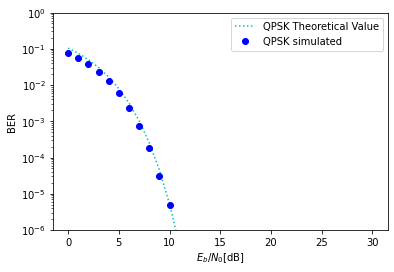

In [ ]:
#理論式
mode = "PSK"
gammaMode = "EbN0"
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)
errorMode = "BER"

plt.plot(
    EbN0,
    errorTheoreticalValue(
        M = 2,
        mode = mode,
        gammaMode = gammaMode,
        gamma = np.power(10.0, EbN0/10.0),
        errorMode = errorMode
    ),
    ':c',
    label = "QPSK Theoretical Value"
)


#実験結果
plt.plot(
    np.loadtxt(path + "/BER_EbN0_QPSK.csv")[0],
    np.loadtxt(path + "/BER_EbN0_QPSK.csv")[1],
    'ob',
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.ylim(10 ** (-6), 1)

plt.legend()

plt.savefig(path + "/BER_EbN0_QPSK.png")

plt.show()

## まとめ


### PSK

#### BER-Eb/N0

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/BER_SNR_BPSK.csv")[0],
    np.loadtxt(path + "/BER_SNR_BPSK.csv")[1],
    'or', 
    label = "BPSK"
)


plt.xlabel("$E_b/N_0$")
plt.ylabel("BER")

plt.yscale("log")

plt.xlim(0, 15)
plt.ylim(10 ** (-5), 1)

plt.title("$E_b/N_0$-BER (PSK)")

plt.legend()